**Machine Learning Overbooking**

*En este proyecto vamos a intentar buscar un patrón el el comportamiento de los "No show" del SAP para poder gestionar mejor los "OB"*

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import missingno as msno
import category_encoders as ce
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

import statsmodels.api as sm
from scipy.stats import gaussian_kde
from statsmodels.stats import diagnostic


from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.experimental import enable_iterative_imputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


plt.style.use('ggplot')

2024-04-05 06:11:45.315510: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 06:11:46.618549: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 06:11:49.738548: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 06:11:53.417451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
data = pd.read_csv('/workspaces/Overbooking/NS.csv',sep=';')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70788 entries, 0 to 70787
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   NDO             70788 non-null  int64 
 1   Fecha de Venta  70788 non-null  object
 2   Fecha de Vuelo  70788 non-null  object
 3   Region POC      70679 non-null  object
 4   Clase           70788 non-null  object
 5   Neto            70788 non-null  int64 
 6   NS              70788 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 3.8+ MB


In [5]:
data.head()

,NDO,Fecha de Venta,Fecha de Vuelo,Region POC,Clase,Neto,NS
0,278,30/03/2022,02/01/2023,AMERICA,N,1,77
1,268,09/04/2022,02/01/2023,AMERICA,P,0,77
2,257,20/04/2022,02/01/2023,AMERICA,A,1,77
3,253,24/04/2022,02/01/2023,AMERICA,A,-1,77
4,235,12/05/2022,02/01/2023,AMERICA,A,1,77


**MISSING VALUES**

In [6]:
print(data.isnull().sum())

NDO                 0
Fecha de Venta      0
Fecha de Vuelo      0
Region POC        109
Clase               0
Neto                0
NS                  0
dtype: int64


**Eliminamos las filas donde hay valores vacíos**

In [7]:
data = data.dropna()

In [8]:
print(data.isnull().sum())

NDO               0
Fecha de Venta    0
Fecha de Vuelo    0
Region POC        0
Clase             0
Neto              0
NS                0
dtype: int64


*Relacion lineal Fecha de Venta vs NS*

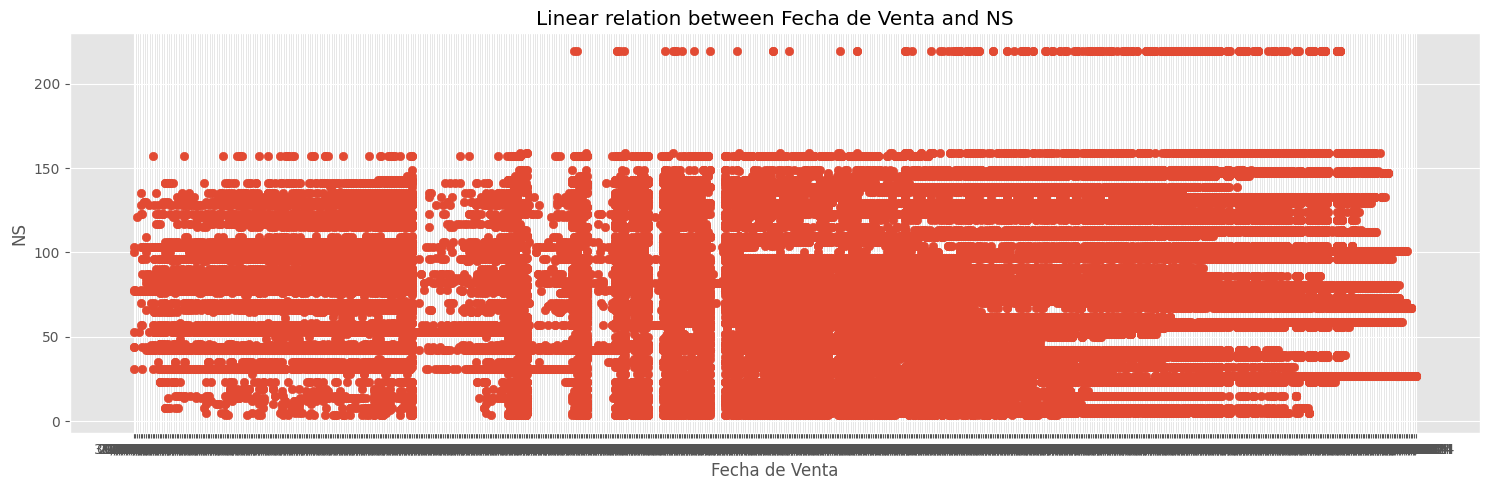

In [9]:


plt.figure(figsize=(15,5))
plt.scatter(data['Fecha de Venta'],data['NS'])
plt.xlabel("Fecha de Venta")
plt.ylabel('NS')
plt.title("Linear relation between Fecha de Venta and NS")
plt.tight_layout()
plt.show()

*Relacion lineal NDO vs NS*

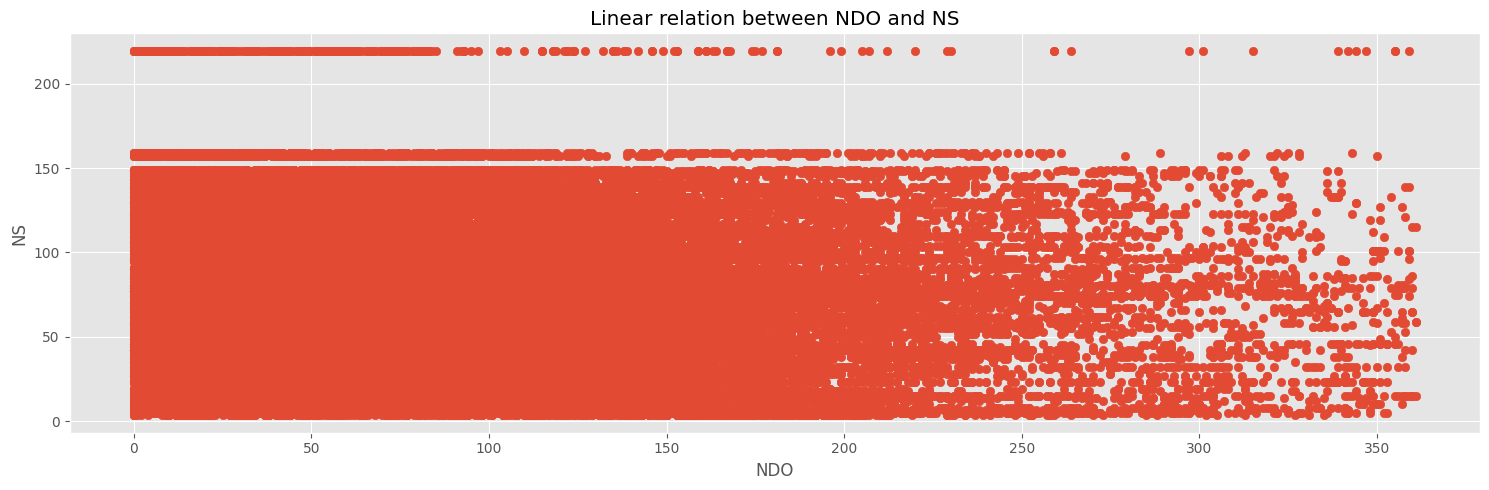

In [21]:
data2 = data[data['NDO'] >= 0]
plt.figure(figsize=(15,5))
plt.scatter(data2['NDO'],data2['NS'])
plt.xlabel("NDO")
plt.ylabel('NS')
plt.title("Linear relation between NDO and NS")
plt.tight_layout()
plt.show()

*Relacion lineal Clase vs NS*

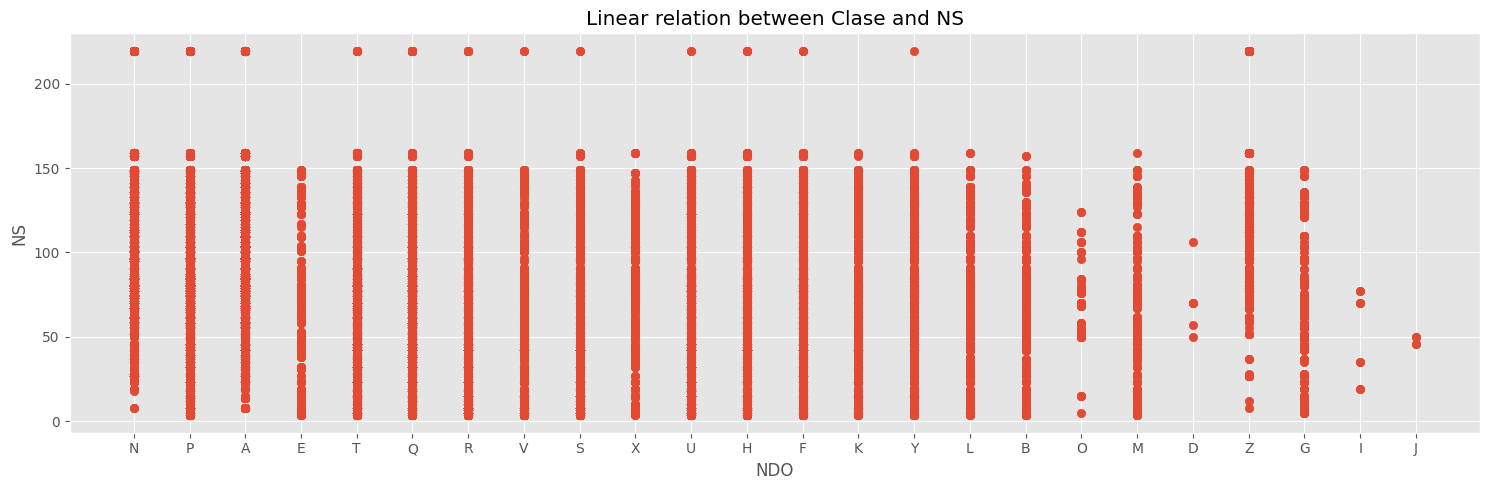

In [11]:
plt.figure(figsize=(15,5))
plt.scatter(data['Clase'],data['NS'])
plt.xlabel("Clase")
plt.ylabel('NS')
plt.title("Linear relation between Clase and NS")
plt.tight_layout()
plt.show()

*NS distribution*

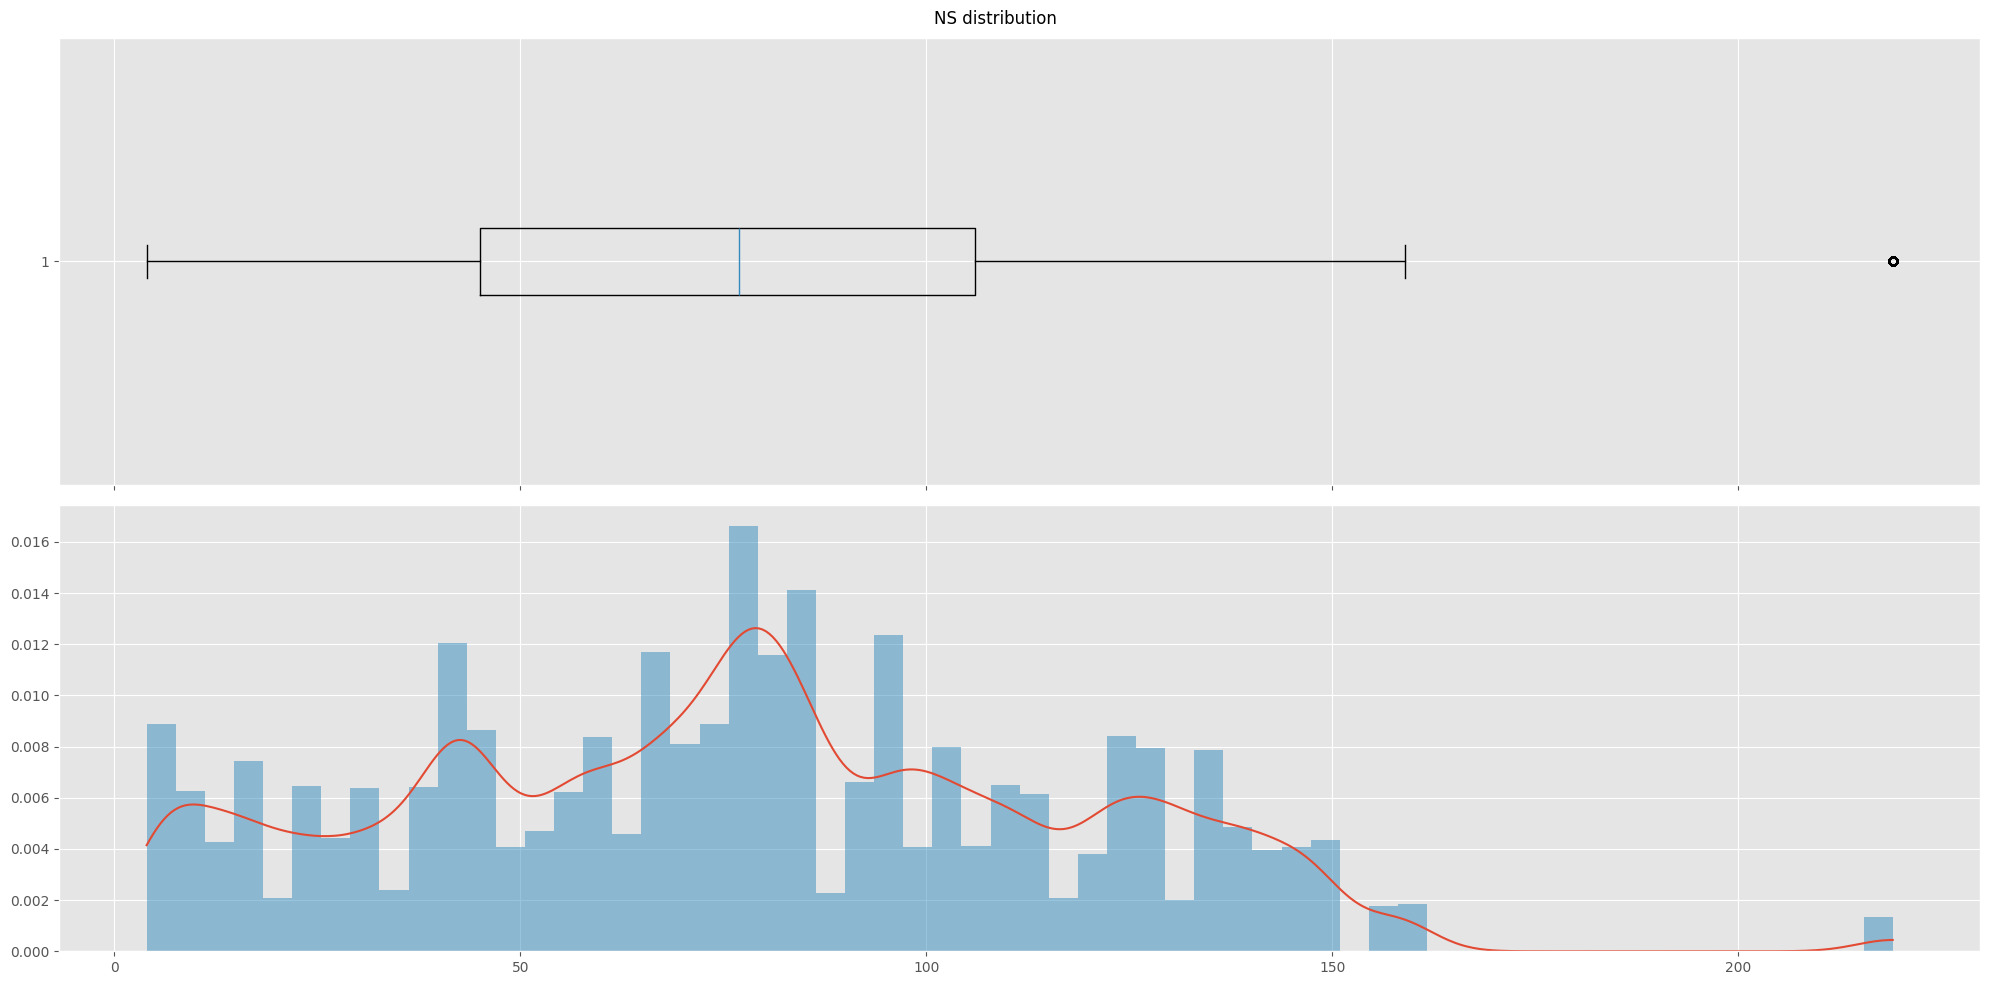

In [12]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,10),sharex=True)

kde = gaussian_kde(data['NS'])
kde_x = np.linspace(data['NS'].min(), data['NS'].max(), 500)

ax[0].boxplot(data['NS'],vert=False)

kde_y = kde(kde_x)

ax[1].plot(kde_x, kde_y, label='KDE')
ax[1].hist(data['NS'],bins=60,alpha=0.5,density=True)

plt.suptitle('NS distribution')
plt.tight_layout()
plt.show()

*Oitliers*

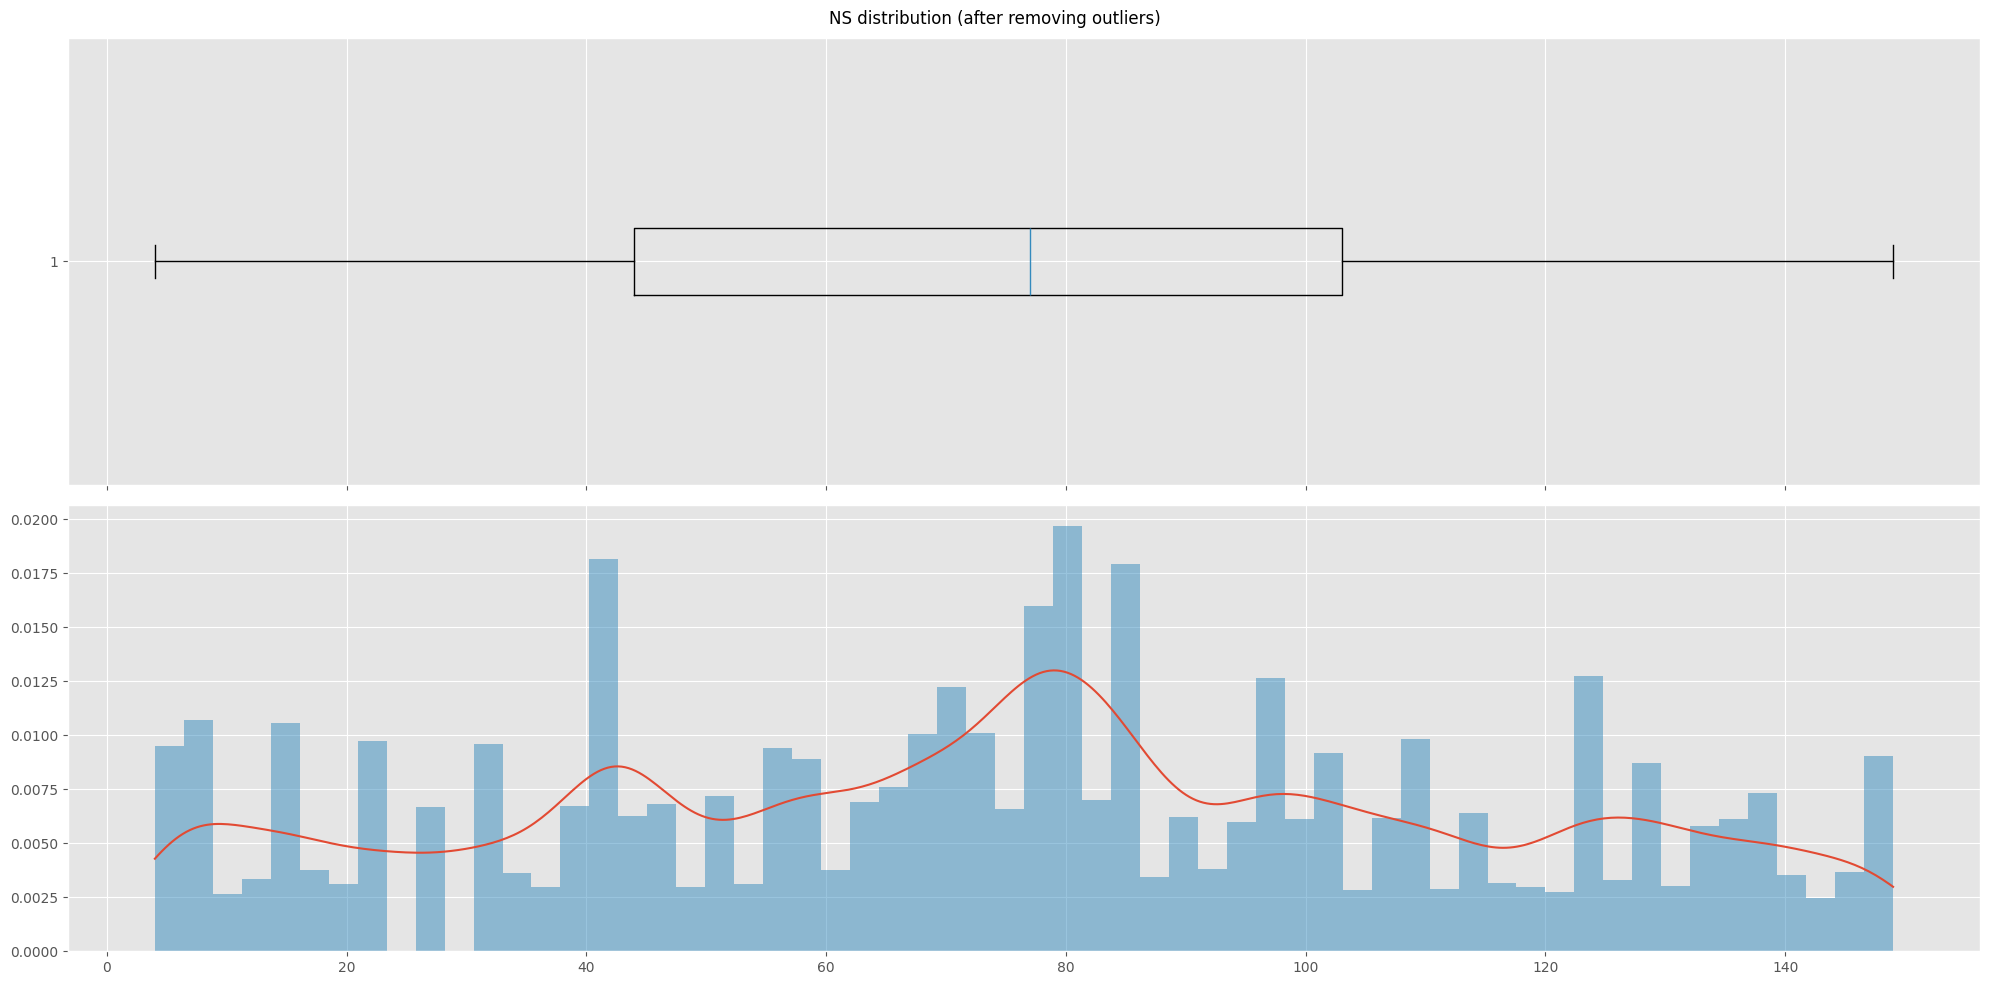

In [13]:
data1 = data.loc[data['NS'] < 150,:]

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,10),sharex=True)

kde = gaussian_kde(data1['NS'])
kde_x = np.linspace(data1['NS'].min(), data1['NS'].max(), 500)

ax[0].boxplot(data1['NS'],vert=False)

kde_y = kde(kde_x)

ax[1].plot(kde_x, kde_y, label='KDE')
ax[1].hist(data1['NS'],bins=60,alpha=0.5,density=True)

plt.suptitle('NS distribution (after removing outliers)')
plt.tight_layout()
plt.show()

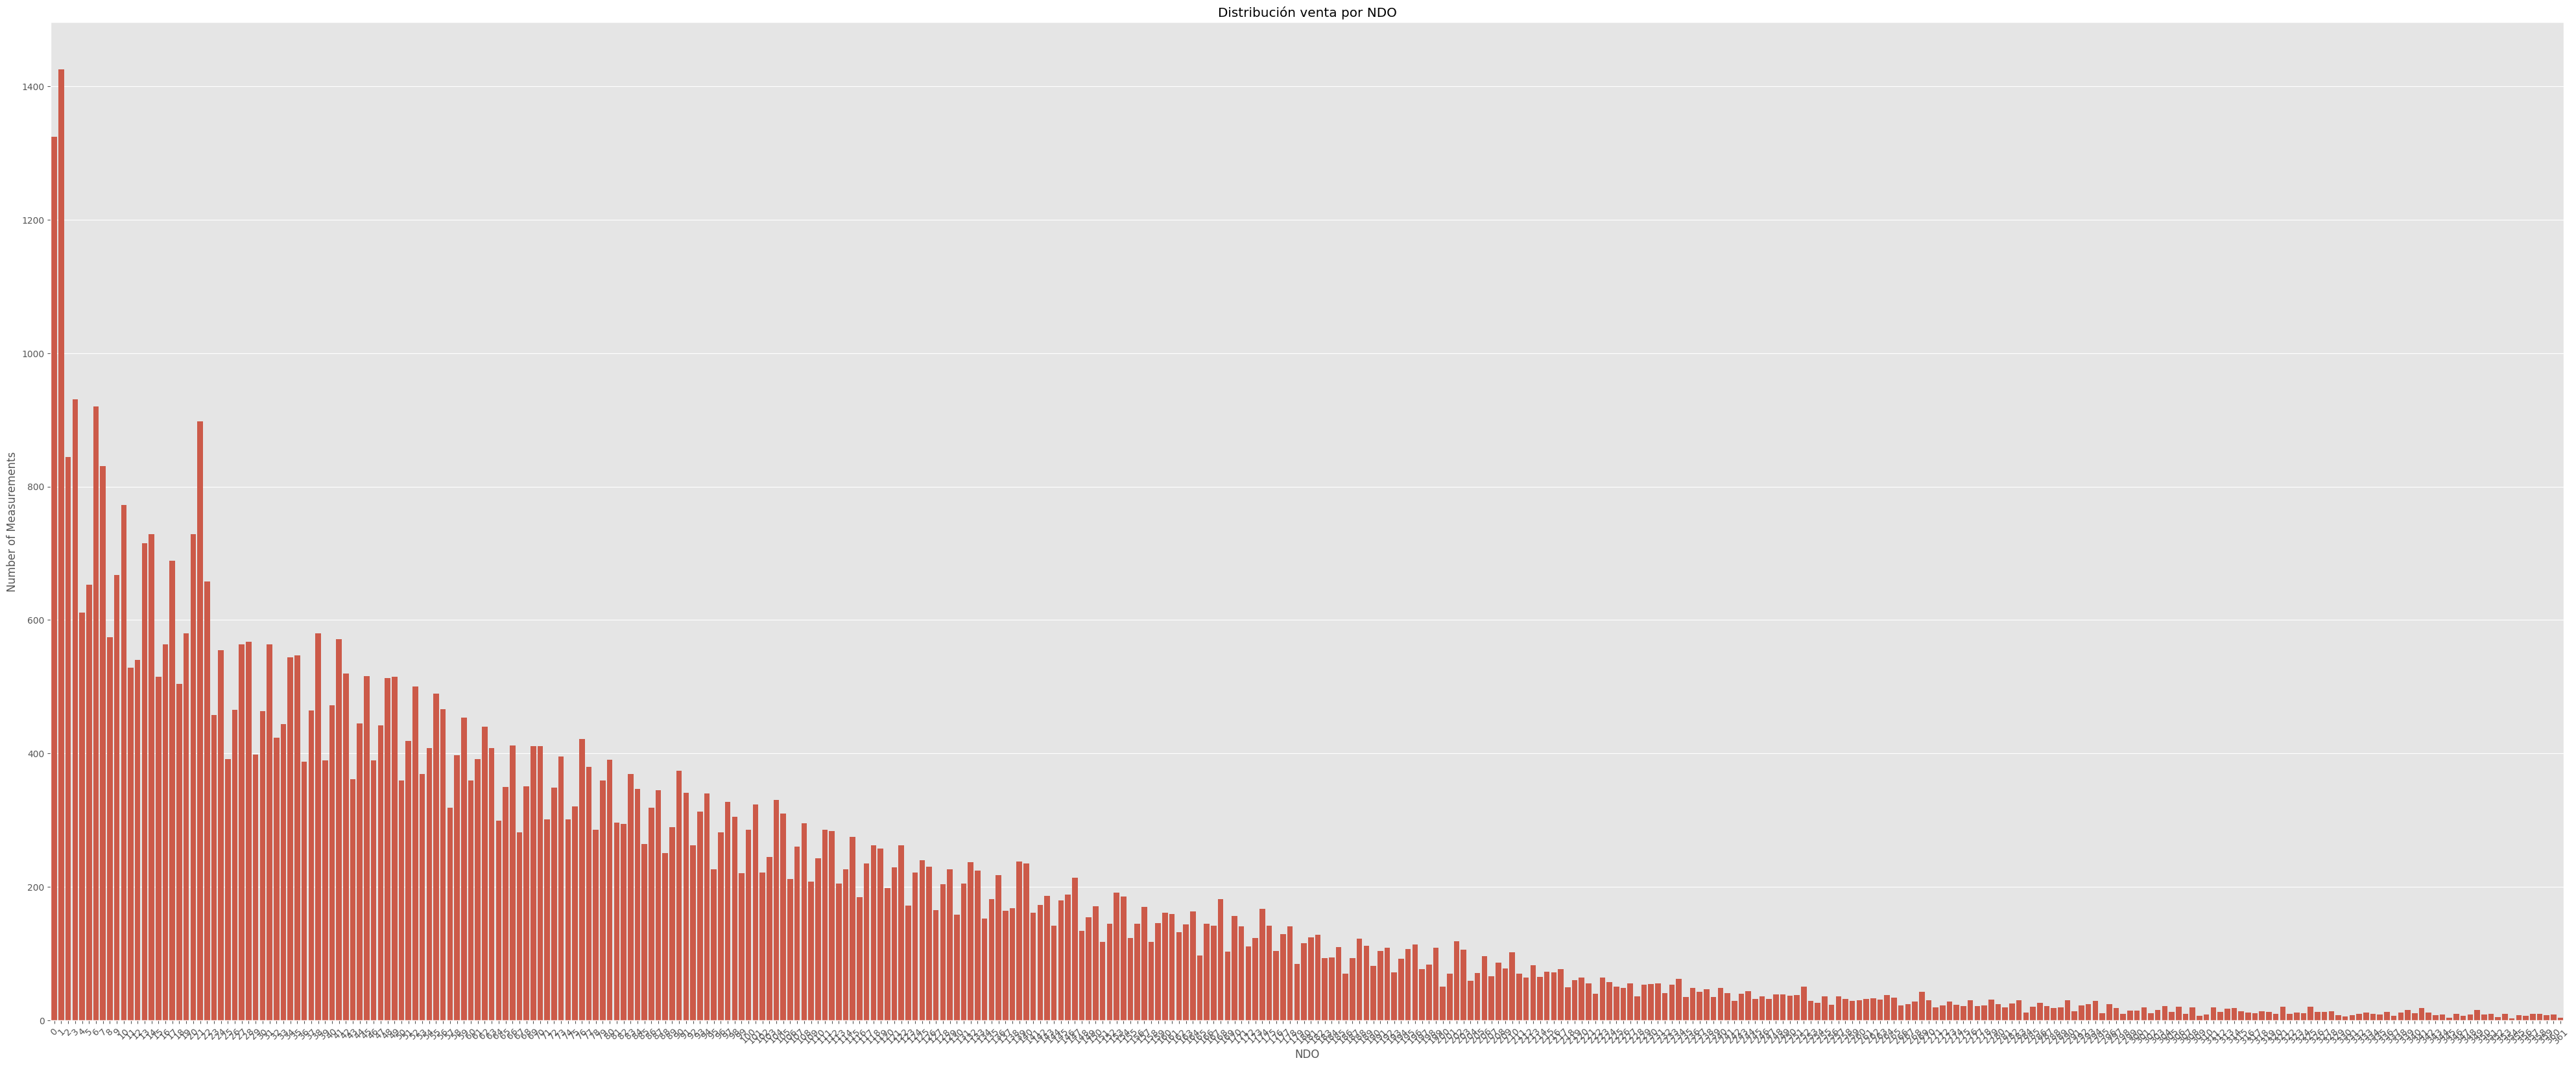

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
data2 = data[data['NDO'] >= 0]
plt.figure(figsize=(50, 20))
sns.countplot(x='NDO', data=data2)
plt.title('Distribución venta por NDO')
plt.xlabel('NDO')
plt.ylabel('Number of Measurements')
plt.xticks(rotation=45)
plt.show()